## Data and Package Loading

In [175]:
# data manipulation
import pandas as pd
import numpy as np

# data viz
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline


import chime

In [176]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [177]:
print("Train:",train_df.shape[0],"house sales, and",train_df.shape[1],'features\nTest:',test_df.shape[0],"house sales, and",test_df.shape[1],'features')
train_df.head()

Train: 1460 house sales, and 81 features
Test: 1459 house sales, and 80 features


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## EDA

In [178]:
data_vars = [f for f in train_df.columns]
data_types = [f for f in train_df.dtypes]

numericas = [f for f in train_df.columns if train_df.dtypes[f] != 'object']
numericas.remove('SalePrice')
numericas.remove('Id')
categoricas = [f for f in train_df.columns if train_df.dtypes[f] == 'object']

df_vars = pd.DataFrame({'var':data_vars, 'dtype':data_types})
df_vars.groupby(['dtype'])['var'].count()

dtype
int64      35
float64     3
object     43
Name: var, dtype: int64

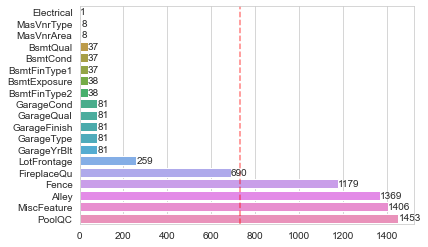

In [179]:
sns.set_style("whitegrid")
nulos = train_df.isnull().sum()
nulos = nulos[nulos > 0]
nulos.sort_values(inplace=True)

ax = sns.barplot(x=nulos, y=nulos.index)
ax.bar_label(ax.containers[0])
plt.axvline(1460/2, color='red', alpha = 0.5, ls = '--')
plt.show()


In [180]:
nulos

Electrical         1
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtExposure      38
BsmtFinType2      38
GarageCond        81
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
LotFrontage      259
FireplaceQu      690
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64

C:\Users\limao\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Log Normal'}, xlabel='SalePrice'>

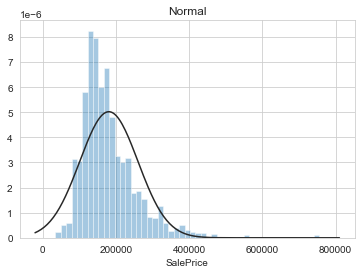

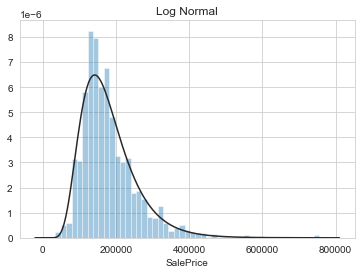

In [181]:
target = train_df['SalePrice']
plt.figure(2); plt.title('Normal')
sns.distplot(target, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(target, kde=False, fit=stats.lognorm)

Log transformation look like the best approach for the target

## Data Processing

Encoding categorical features using the mean of target

In [182]:
def target_encoder(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

categoricas_e = []
for ft in categoricas:
    target_encoder(train_df, ft)
    categoricas_e.append(ft+"_E")

In [183]:
train_df.drop('Id', axis = 1, inplace=True)
test_df.drop('Id', axis = 1, inplace=True)

train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
y_train = train_df['SalePrice'].reset_index(drop=True)

Features Processing

In [184]:
x_train = train_df.drop('SalePrice', axis = 1)
x_test = test_df
features_full = pd.concat([x_train, x_test]).reset_index(drop=True)

In [190]:
# filling NAs
features_full['Functional'] = features_full['Functional'].fillna('Typ') 
features_full['Electrical'] = features_full['Electrical'].fillna("SBrkr") 
features_full['KitchenQual'] = features_full['KitchenQual'].fillna("TA") 
features_full["PoolQC"] = features_full["PoolQC"].fillna("None")
features_full['Exterior1st'] = features_full['Exterior1st'].fillna(features_full['Exterior1st'].mode()[0]) 
features_full['Exterior2nd'] = features_full['Exterior2nd'].fillna(features_full['Exterior2nd'].mode()[0])
features_full['SaleType'] = features_full['SaleType'].fillna(features_full['SaleType'].mode()[0])

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features_full[col] = features_full[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features_full[col] = features_full[col].fillna('None')

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features_full[col] = features_full[col].fillna('None')

features_full['MSZoning'] = features_full.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

objects = []
for i in features_full.columns:
    if features_full[i].dtype == object:
        objects.append(i)
features_full.update(features_full[objects].fillna('None'))

features_full['LotFrontage'] = features_full.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features_full.columns:
    if features_full[i].dtype in numeric_dtypes:
        numerics.append(i)
features_full.update(features_full[numerics].fillna(0))

In [ ]:
features_full['MSSubClass'].dtype

dtype('int64')

### Correlation of target and categorical features

In [ ]:
# output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': y_test_out})
# output.to_csv('submission.csv', index=False)